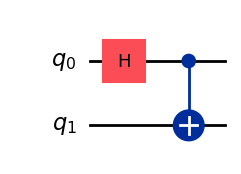

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")


In [2]:
# Set up six different observables.
observables_labels = ["ZZ", "ZI", "IZ", "XX", "XI"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [3]:
# If you did not previously save your credentials, use the following line instead:
service = QiskitRuntimeService(channel="ibm_quantum", token="8547bb879f21e9ed11ae4b2b65c160e42be264a0c1b431106761a1dc05e1d6e7efe44b883dc5f3c2ded862f27827787ac37766efc785b77f8abcfc88b9c9310c")
#service = QiskitRuntimeService()

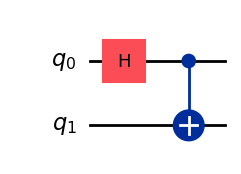

In [4]:

 
# Use the following code instead if you want to run on a simulator:
#from qiskit_ibm_runtime.fake_provider import FakeCairoV2
#backend = FakeCairoV2()

# Run on the least-busy backend you have access to
backend = service.least_busy(simulator=True, operational=True)
#backend = service.least_busy(simulator=False, operational=True)  #if you want to run on QPU
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)

In [5]:
# Construct the Estimator instance we want to use.
 
estimator = Estimator(backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 1000
 
observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, observables)])
 
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

C:\Users\STUDENT.DESKTOP-AG6COQS\AppData\Roaming\Python\Python311\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Cloud simulators have been deprecated and will be removed on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


In [6]:
print(pub_result)
print(job.result)

PubResult(data=DataBin<5>(evs=[ 1.          0.03515625  0.03515625  1.         -0.00390625], stds=[0.         0.02973308 0.02973308 0.         0.04048909], ensemble_standard_error=[0.         0.03123068 0.03123068 0.         0.03124976]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {'twirled_readout_errors': [[0, 0.0], [1, 0.0]]}, 'num_randomizations': 16})
<bound method RuntimeJobV2.result of <RuntimeJobV2('cod11nvimm49f6efk010', 'estimator')>>


<ErrorbarContainer object of 3 artists>

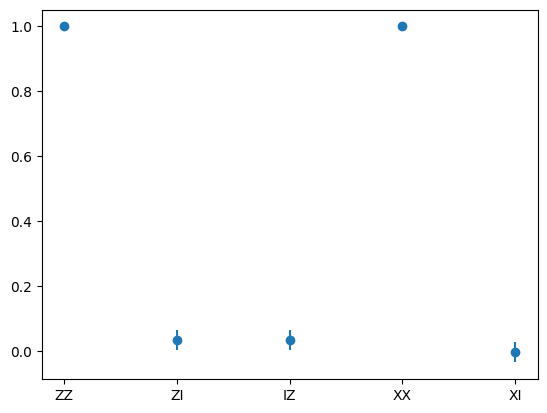

In [7]:
# Plot the result
 
from matplotlib import pyplot as plt
 
data = observables_labels
values = pub_result.data.evs
 
errors = pub_result.data.ensemble_standard_error
 
plt.errorbar(observables_labels, values, yerr=errors, fmt="o")